# Corner plot for the projection effect of individual triaxial profiles

Xiangyu Huang, 2024

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import corner
import os

In [2]:
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from deproject.projection import Projection
from deproject.Profiles.SIS_truncated_angular import SIS_truncated_angular
from deproject.Util.orientation import Sphere_random_point
from deproject.Cosmo.default_cosmo import get_default_lens_cosmo

## Many projections of a single halo

In [3]:
def single_halo_proj(halo_kwargs, proj_num, lens_cosmo, save = True):

    halo_id = halo_kwargs.get('halo_id')
    sigma_rm = halo_kwargs.get('sigma_random_los')
    zeta = halo_kwargs.get('zeta')
    xi = halo_kwargs.get('xi')

    # calculate sigma_crit for kappa profile 
    sigma_crit = lens_cosmo.Sigma_crit / 1e6 # [M_sun/kpc^2]

    # define range of radial variable
    R_proj = np.geomspace(0.0001, 150, num=100)
    R_interp = np.geomspace(0.001, 50, num = 200)

    # define a SIS profile
    profile_sis = SIS_truncated_angular(sigma_v = sigma_rm, lens_cosmo = lens_cosmo)

    # project onto random direction
    ellipticity_list = np.zeros(proj_num)
    theta_list, phi_list = Sphere_random_point(num = proj_num)
    effective_thetaE_list = np.zeros(proj_num)

    for j in range(proj_num):

        projection = Projection(zeta=zeta, xi=xi, theta=theta_list[j], phi=phi_list[j])
        radial_sis = projection.RadialProfile(R=R_proj, profile=profile_sis, R_align='average', interpolate=True) # circularized radial profile
        radial_sis = radial_sis(R_interp)

        ellipticity = projection.Ellipticity()
        ellipticity_list[j] = ellipticity

        kappa = radial_sis / sigma_crit
        effective_thetaE = LensProfileAnalysis.effective_einstein_radius_from_radial_profile(R_interp, kappa)
        effective_thetaE_list[j] = effective_thetaE

        print("halo_id = {}" .format(halo_id), ', e = {:.3f}' .format(ellipticity),', theta_E = {:.3f}' .format(effective_thetaE))
    
    data_projected = np.vstack([effective_thetaE_list, ellipticity_list, theta_list, phi_list])

    if save:
        working_dir = os.getcwd()
        individual_folder = 'data_individual'
        save_dir = os.path.join(working_dir, individual_folder)
        np.save(save_dir + '/corner_data_{}.npy' .format(halo_id), data_projected)

    return data_projected

## Load catalog

In [4]:
working_dir = os.getcwd()
file_name = '/tng_catalog/tng_sigma_shape_cut/tng_100_finite_sigma_shape_cut.pkl'
file_path = os.path.join(os.path.dirname(working_dir) + file_name)
cat_100 = pd.read_pickle(file_path)

In [5]:
lens_cosmo = get_default_lens_cosmo()

## Plot or calculate

In [6]:
def plot_single_halo(data, halo_kwargs, theta_E_sph):

    data_plot = deepcopy(data)

    print(data_plot.shape)

    data_plot[2] = np.cos(data_plot[2])

    hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True
    , 'color': 'skyblue'
    , 'data_kwargs': {'ms': 5, 
    'alpha': 0.2
    }}

    fig = corner.corner(data_plot.T, labels=[r'$\theta_E$ [arcsec]', '$e$', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 22}, **hist2dkwargs, hist_kwargs={'linewidth': 2})

    axes = np.array(fig.axes).reshape((4, 4))

    mean_thetaE = np.mean(data_plot[0, :])
    print('mean theta_e - spherical theta_e = {:.5f}' .format(mean_thetaE - theta_E_sph))
    print()

    axes[0, 0].axvline(theta_E_sph, lw = 2, c = 'salmon')
    axes[0, 0].axvline(mean_thetaE, lw = 2, ls = '--', c = 'skyblue')

    plt.plot([], [], c = 'skyblue', lw = 2, label = 'triaxial, random projection')
    plt.plot([], [], c = 'skyblue', lw = 2, ls = '--', label = r'mean $\theta_E$ = {:.3f}' .format(mean_thetaE) + '\"')
    plt.plot([], [], c = 'salmon', lw = 2, label = r'spherical $\theta_E$ = {:.3f}' .format(theta_E_sph) + '\"' )

    fig.legend(frameon = False, bbox_to_anchor=(0., 0.95, 0.98 ,0), fontsize=22)

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=16)

    fig.suptitle(r'$p = {:.2f},\quad q = {:.2f}$' .format(halo_kwargs.get('zeta'), halo_kwargs.get('xi')), size = 26, y=1.02)

    return fig

(4, 100)
mean theta_e - spherical theta_e = -0.00240



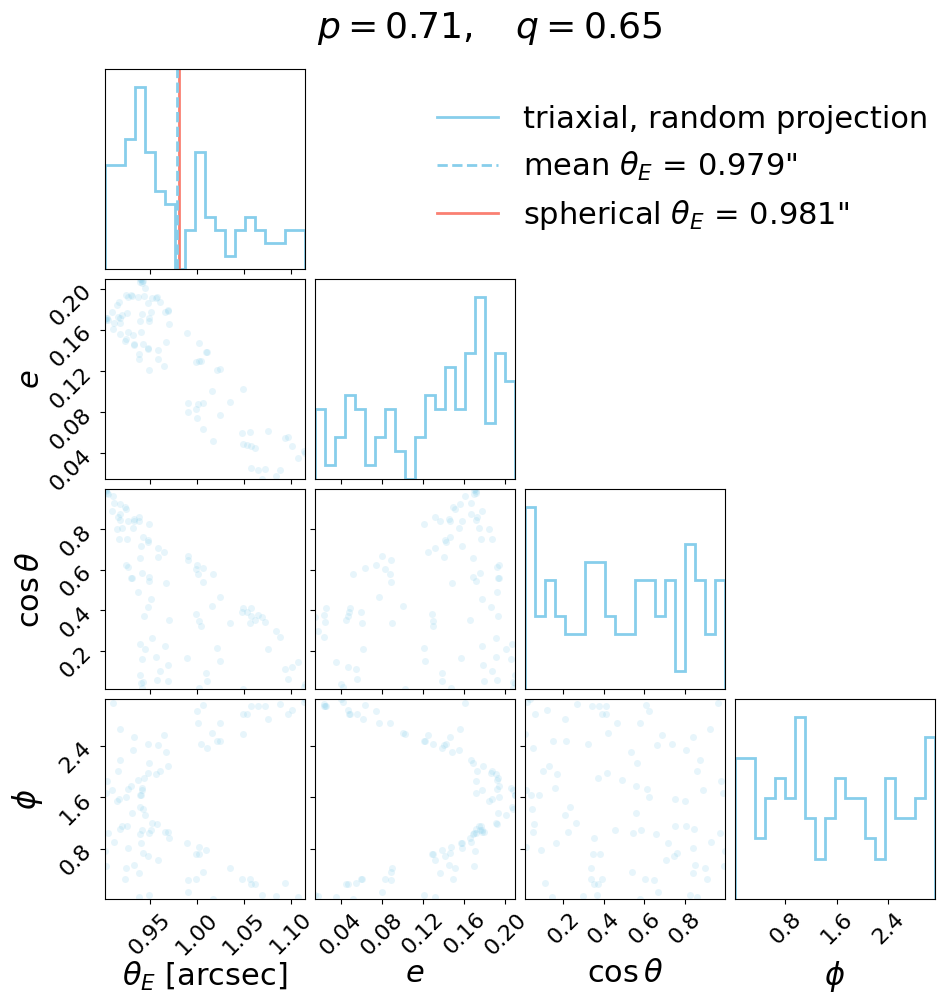

In [7]:
halo_id_list = [137885]

recompute_projection = []
num_projection = 100

theta_E_sph_all = lens_cosmo.sis_sigma_v2theta_E(cat_100['sigma_random_los'].values)

for halo_id in halo_id_list:

    halo_kwargs = cat_100.loc[cat_100['halo_id'] == halo_id].to_dict('records')[0]

    if halo_id in recompute_projection:
        data_single = single_halo_proj(halo_kwargs, num_projection, lens_cosmo)
    
    # access data
    working_dir = os.getcwd()
    individual_folder = 'data_individual'
    save_dir = os.path.join(working_dir, individual_folder)
    data_single = np.load(save_dir + '/corner_data_{}.npy' .format(halo_id))

    # plot
    halo_ind = np.where(cat_100['halo_id'] == halo_id)[0]
    theta_E_sph = theta_E_sph_all[halo_ind][0]
    fig = plot_single_halo(data_single, halo_kwargs, theta_E_sph)
    
